**When mlp sweeps the rankings, I think we need to try more models. Although mlp can achieve high scores, it lacks cross-learning of features. So here I open a notebook based on deepfm, hoping to discuss and learn together.**

**（在mlp横扫排行榜的时候，我认为我们需要去尝试更多的模型。mlp虽然可以取得很高的分数，但是缺少对于特征的交叉学习。所以在这里我公开基于deepfm的notebook,希望一起讨论学习。）**

The architecture of deepfm

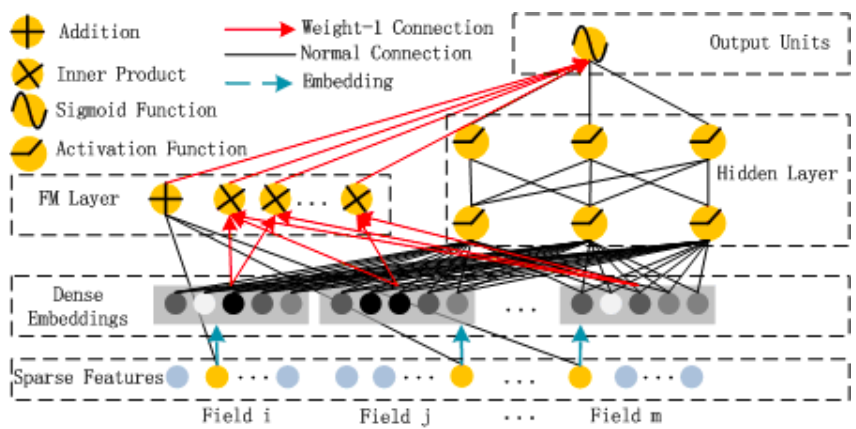

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras.layers as Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

import tensorflow.keras.layers as layer
%matplotlib inline

 **LOAD DATA**

In [ ]:
data = pd.read_csv("../input/jane-street-market-prediction/train.csv")
data = data.astype({c: np.float32 for c in data.select_dtypes(include='float64').columns})  # limit memory use
data['action'] = (data['resp'] > 0).astype('int')
features = [c for c in data.columns if 'feature' in c]
sfeature = features[0]
dfeature = features[1:]
data[features].head()

* In order to make better use of deepfm for feature crossing, we need to divide the numerical features into buckets（为了更好的应用deepfm来进行特征交叉，我们需要对数值特征进行分桶）
* In this block, a universal bin function is defined, which can realize equal frequency bin and equal distance bin, and can help to realize feature bin easily（在这里定义了一个具有普适性的分箱函数，可以实现等频分箱和等距分箱，可以帮助轻松实现特征分箱）

In [ ]:
bindict = {}
def binning(df,col,method,bins,bindict):
    uniqs=df[col].nunique()
    if uniqs<=bins:
        raise KeyError('nunique is smaller than bins: '+col)
        return 
    def ff(x,fre_list):
        if pd.isnull(x):
            return -1
        if x<=fre_list[0]:
            return 0
        elif x>fre_list[-1]:
            return len(fre_list)-1
        else :
            for i in range(len(fre_list)-1):
                if x>fre_list[i] and x<=fre_list[i+1]:
                    return i
    # 等距分箱Isometric bin
    if method=='distance':
        umax=np.percentile(df[col],99.99)
        umin=np.percentile(df[col],0.01)
        step=(umax-umin)/bins
        fre_list=[umin+i*step for i in range(bins+1)]
        return df[col].map(lambda x:ff(x,fre_list))
    # 等频分箱Equal frequency bin
    elif method=='frequency' :
        fre_list=[np.nanpercentile(df[col],100/bins*i) for i in range(bins+1)]
        fre_list=sorted(list(set(fre_list)))
        bindict[col] = fre_list
        return df[col].map(lambda x:ff(x,fre_list))

In [ ]:
#Binning the original features at equal frequency （将原始特征等频分箱）
for fea in dfeature:
    data[fea] = binning(df = data,col = fea, method='frequency',bins=10, bindict=bindict)
data.to_csv("spasetrain.csv")
data.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
for feat in features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
data.head()

* First-order sparse features
* Here is a separate input for each sparse feature,
* The purpose is to facilitate the construction of second-order combination features later
* 一阶sparse特征
* 这里单独对每一个 sparse 特征构造输入，
* 目的是方便后面构造二阶组合特征

In [ ]:
sparse_inputs = []
for f in features:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)
    
sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = features[i]
    voc_size = data[f].nunique()
    # Use l2 regularization to prevent overfitting 使用 l2 正则化防止过拟合
    reg = tf.keras.regularizers.l2(0.5)
    _embed = Embedding(voc_size, 1, embeddings_regularizer=reg)(_input)
    # Since the result of Embedding is two-dimensional, 由于 Embedding 的结果是二维的，
    # Therefore, if you need to add the Dense layer after Embedding, you need to connect to the Flatten layer first
    # （因此如果需要在 Embedding 之后加入 Dense 层，则需要先连接上 Flatten 层）
    _embed = Flatten()(_embed)
    sparse_1d_embed.append(_embed)
fst_order_sparse_layer = Add()(sparse_1d_embed)

* Second-order sparse feature crossover

In [ ]:
#二阶sparse特征交叉
# embedding size
k = 8

# 只考虑sparse的二阶交叉
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = features[i]
    voc_size = data[f].nunique()
    reg = tf.keras.regularizers.l2(0.7)
    _embed = Embedding(voc_size, k, embeddings_regularizer=reg)(_input)
    sparse_kd_embed.append(_embed)

1. Join all the embeddings of sparse to get a matrix of (n, k), where n is the feature number and k is the embedding size
2. Sum first and then square
3. Square first and then sum
4. Subtract and divide by 2

In [ ]:
# 1.将所有sparse的embedding拼接起来，得到 (n, k)的矩阵，其中n为特征数，k为embedding大小
concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed)  # ?, n, k
# 2.先求和再平方
sum_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)  # ?, k
square_sum_kd_embed = Multiply()([sum_kd_embed, sum_kd_embed])  # ?, k
# 3.先平方再求和
square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed]) # ?, n, k
sum_square_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed)  # ?, k
# 4.相减除以2
sub = Subtract()([square_sum_kd_embed, sum_square_kd_embed])  # ?, k
sub = Lambda(lambda x: x*0.5)(sub)  # ?, k
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)  # ?, 1


* dnn

In [ ]:
##dnn部分
flatten_sparse_embed = Flatten()(concat_sparse_kd_embed)  # ?, n*k
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(flatten_sparse_embed))  # ?, 256
fc_layer = Dropout(0.3)(Dense(256, activation='relu')(fc_layer))  # ?, 256
fc_layer = Dropout(0.1)(Dense(256, activation='relu')(fc_layer))  # ?, 256
fc_layer_output = Dense(1)(fc_layer)  # ?, 1

* the output layer

In [ ]:
#输出结果
output_layer = Add()([fst_order_sparse_layer, snd_order_sparse_layer, fc_layer_output])
output_layer = Activation("sigmoid")(output_layer)

* Compire the model

In [ ]:
#编译模型
model = Model(sparse_inputs, output_layer)
model.summary()

In [ ]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

****Training****

In [ ]:
#训练
data = data.query('date > 85').reset_index(drop = True) 
data = data.query('weight > 0').reset_index(drop = True)
valid = data.loc[(data.date >= 451) & (data.date < 500)].reset_index(drop=True)
train = data.loc[data.date < 499].reset_index(drop=True)
train_data = train.loc[:, features]
valid_data = valid.loc[:, features]
train_label = [train.loc[:, "action"].values]
val_label = [valid.loc[:, "action"].values]
del data

In [ ]:
train_sparse_x = [train_data[f].values for f in features]
val_sparse_x = [valid_data[f].values for f in features]
model.fit(train_sparse_x, 
          train_label, epochs=50, batch_size=5000,
          validation_data=(val_sparse_x, val_label),
         )
model.save_weights("deepfmweights.hdf5")